<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_cnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RxVision CNN 1

This is the baseline model for this project; I am aiming for a validation accuracy of at least 50% and will train at a low resolution for 50 epochs. 

# Setup

## Environment Prep

### Package Import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import time
import itertools

from PIL import Image
from scipy import ndimage

import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers

import multiprocessing

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from PIL import ImageFile

np.random.seed(123)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Functions

In [0]:
def model_scores(model):
  '''Return validation accuracy and real-world accuracy after evaluating provided model'''
  model_val_results = model.evaluate(val_generator)
  modelacc = model_val_results[1]
  model_rw_results = model.evaluate(realworld_generator)
  modelrw = model_rw_results[1]
  print('\nValidation Accuracy: ' + str(int(modelacc*100)) + '%' + '\nReal-world Accuracy: ' + str(int(modelrw*100)) + '%')

def model_acc_val_plot(model):
  '''Return train and validation loss and accuracy plots from hist log'''
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  acc = hist['acc']
  val_acc = hist['val_acc']

  loss = hist['loss']
  val_loss = hist['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(0,len(hist)), acc, label='Training Accuracy')
  plt.plot(range(0,len(hist)), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(range(0,len(hist)), loss, label='Training Loss')
  plt.plot(range(0,len(hist)), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_AccLoss.png'.format(model.name))
  plt.show()

def model_confusion(model):
  '''Return a confusion matrix for predictions made from evaluating the proviced model'''
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes

  cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

  fig, ax = plt.subplots(figsize=(8,6.75))  
  pal = sns.light_palette("#ffab40", as_cmap=True)
  sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
  plt.ylabel('Class Actual', fontweight='bold')
  plt.xlabel('Class Predicted', fontweight='bold')
  plt.title('/content/drive/My Drive/RxID2/Images/{}_Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_conf'.format(model.name))

def predict_plot(model):
  '''
  Return an image plot with class, number of correct predictions,
  and predicted classes (ordered by descending frequency)
  '''
  %cd /content/drive/My Drive/RxID2/Data/Download
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
  samplesdfx = dfx.groupby(['NDC']).min().reset_index()
  sampleslist2 = samplesdfx.FILE.tolist()
  #len(sampleslist2)

  samplefiles = []
  for image in sampleslist2:
      smplsplt = image.split('/')
      keep = smplsplt[-1]
      keep = keep[:-4]
      keep= keep +('.JPG')
      samplefiles.append(keep)

      
  #for file in os.listdir():
  drgimg = os.listdir()
  images = []
  for file in samplefiles:
      data = plt.imread(file)
      images.append(data)
  plt.figure(figsize=(15,15))
  columns = 5

  for i, image in enumerate(images): # iterate through the images in the array 'images'
      k = i * class_size
      j = (i + 1) * class_size
      trues = int(y_true[k:j].mean())
      preds = list(y_pred[k:j]).count(trues)
      lst = list(y_pred[k:j])
      preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
      for pred in lst:
          preddict[pred] +=1
      preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
      for k, v in list(preddict.items()):
          if v == 0:
              del preddict[k]
      predlist = list(preddict.keys())
      dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
      dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
      title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
      plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
      plt.margins(tight=True) # not sure which margins this is impacting
      plt.title(title,fontweight='semibold',fontsize='10')
      plt.imshow(image)
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.savefig('/content/drive/My Drive/RxID2/Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...
  %cd ../..
def real_world_predicts(model):
  '''Return predicted classes for real world images using provided model'''
  pred = model.predict(realworld_generator)
  y_pred=np.argmax(pred,axis=1)
  print('\nReal-world predictions 0-14: ', y_pred)

## Data Prep

### Data import

In [0]:
df = pd.read_csv('/content/drive/My Drive/RxID2/Data/rxid15.csv')

In [0]:
train_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/train'
val_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/validation'
realworld_folder = '//content/drive/My Drive/RxID2/Data/RxID2_split/realworld2'

# Model

In [37]:
BATCH_SIZE = 32
IMG_SHAPE  = 28 
EPOCHS = 50


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                    ).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)
# labels = list((val_generator.class_indices).values())

Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 15 images belonging to 15 classes.


In [38]:
model = models.Sequential(name='rxv_cnn_1')

model.add(layers.Conv2D(128, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3))) 

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

csv_logger = CSVLogger('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), separator=',', append=False)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

Model: "rxv_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                61455     
Total params: 138,831
Trainable params: 138,831
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count(),
                    verbose=2)
model.save('/content/drive/My Drive/RxID2/Models/model_{}'.format(model.name))

Epoch 1/50
 - 7s - loss: 2.7241 - acc: 0.1067 - val_loss: 2.7579 - val_acc: 0.2000
Epoch 2/50
 - 7s - loss: 2.6374 - acc: 0.2033 - val_loss: 2.7008 - val_acc: 0.1733
Epoch 3/50
 - 7s - loss: 2.5190 - acc: 0.1800 - val_loss: 2.6185 - val_acc: 0.1867
Epoch 4/50
 - 7s - loss: 2.3245 - acc: 0.2367 - val_loss: 2.2099 - val_acc: 0.2800
Epoch 5/50
 - 7s - loss: 2.1748 - acc: 0.3133 - val_loss: 2.1349 - val_acc: 0.4133
Epoch 6/50
 - 6s - loss: 1.9828 - acc: 0.3933 - val_loss: 1.7817 - val_acc: 0.3867
Epoch 7/50
 - 6s - loss: 1.8009 - acc: 0.5033 - val_loss: 2.3098 - val_acc: 0.3867
Epoch 8/50
 - 6s - loss: 1.6335 - acc: 0.4967 - val_loss: 1.7863 - val_acc: 0.4800
Epoch 9/50
 - 6s - loss: 1.4642 - acc: 0.5767 - val_loss: 1.8560 - val_acc: 0.5200
Epoch 10/50
 - 6s - loss: 1.3603 - acc: 0.5867 - val_loss: 1.9731 - val_acc: 0.5200
Epoch 11/50
 - 6s - loss: 1.2536 - acc: 0.6533 - val_loss: 2.2484 - val_acc: 0.5467
Epoch 12/50
 - 6s - loss: 1.1144 - acc: 0.6767 - val_loss: 2.1684 - val_acc: 0.5467
E

# Analysis

In [43]:
hist = pd.read_csv('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), sep=',', engine='python')

model_scores(model)

real_world_predicts(model)

1/1 [==============================] - 2s 2s/step

Validation Accuracy: 74%
Real-world Accuracy: 13%

Real-world predictions 0-14:  [ 6  5  5 14  5  3  5  5  5 12 10 11  3  3  5]


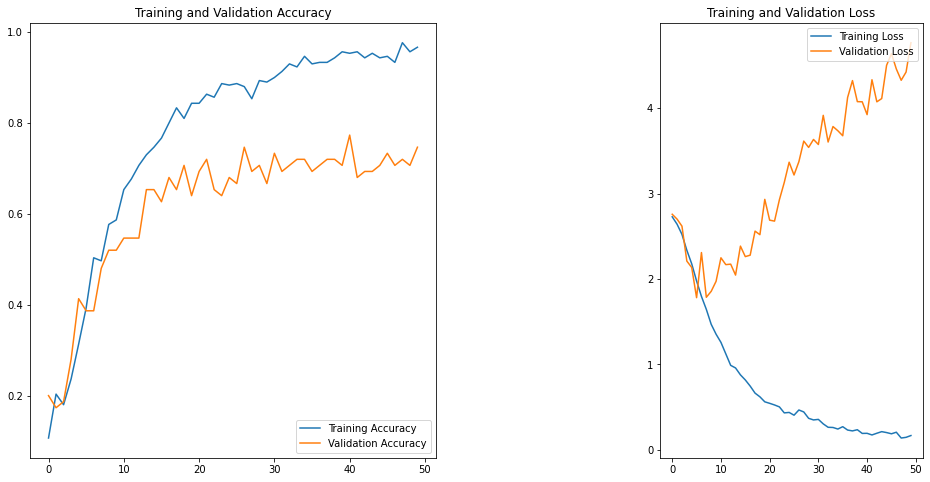

In [44]:
model_acc_val_plot(model)

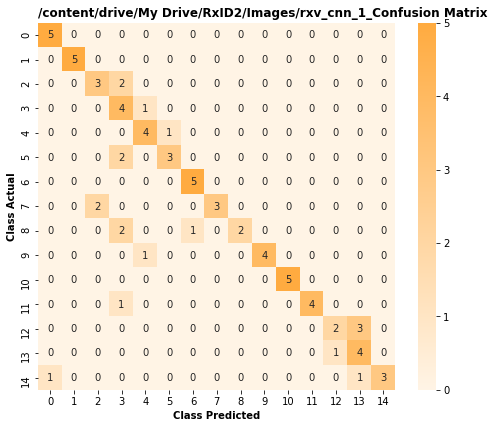

In [48]:
model_confusion(model)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


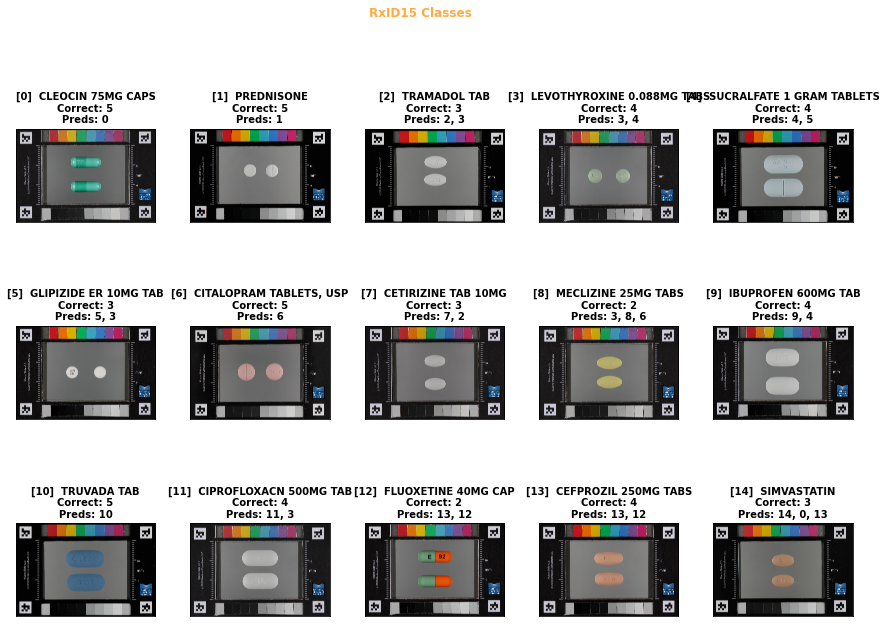

In [46]:
predict_plot(model)